<a href="https://colab.research.google.com/github/brunolucian/NeuralStyleTranfer/blob/master/styled_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Necessary Packages

import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils, to_categorical
from skimage.transform import resize   # for resizing images
import os
import tqdm
from tqdm import tqdm,tqdm_pandas
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras import applications,models, losses,optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
import cv2
from glob import glob
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
import scipy as sp
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# from hyperas.distributions import choice, uniform, conditional
import hyperopt
from sklearn.model_selection import train_test_split
from keras.utils import Sequence, to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from os import listdir
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,LSTMCell
from keras.layers.merge import add
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from skimage.io import imread, imshow, imread_collection, concatenate_images
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from __future__ import print_function, division
from builtins import range, input
from keras.preprocessing import image   # for preprocessing the images
from __future__ import print_function, division
from builtins import range,input
from datetime import datetime
import scipy

Using TensorFlow backend.


In [0]:
# !pip install hyperas

Vamos criar uma função para pré processar o conteudo e o estilo antes de passar para VGG-16. Temos que manter o "shape" em (224,224) já que é o padrãão para VGG-16.


In [0]:
# from google.colab import files
# files.upload()

In [4]:
def load_preprocess_img(p,shape = None):
    Img = image.load_img(p, target_size=shape)
    X = image.img_to_array(Img)
    X = np.expand_dims(X,axis=0)    
    X = preprocess_input(X)
    return X

def preprocess_img(frame,shape = None):
    X = np.expand_dims(frame,axis=0)    
    X = preprocess_input(X.astype(('float64')))
    return X
    

#Loading style image
    
# style_img = load_preprocess_img(p = 'van-gogh-bedroom.jpg', shape=(224,224))
style_img = load_preprocess_img(p = 'techday_04.jpeg', shape=(224,224))
batch_shape = style_img.shape
shape = style_img.shape[1:]
shape

(224, 224, 3)

In [0]:
# shape = (224,224,3)

#Content model define
def vgg_avg_pooling(shape):
    vgg = VGG16(input_shape=shape,weights='imagenet',include_top=False)
    model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling    
            model.add(AveragePooling2D())
        else:
            model.add(layer)
    return model   

def vgg_cutoff(shape,num_conv):
    if num_conv<1|num_conv>13:
        print('Error layer must be with in [1,13]')
    model = vgg_avg_pooling(shape)
    new_model = Sequential()
    n=0
    for layer in model.layers:
        new_model.add(layer)
        if layer.__class__ == Conv2D:
            n+=1
        if n >= num_conv:
            break
    return new_model

#Style loss comutation graph

def gram_matrix(img):
    # input is (H, W, C) (C = # feature maps)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img,(2,0,1)))
    # now, calculate the gram matrix
    # gram = XX^T / N
    gram_mat = K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return gram_mat 

def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y)-gram_matrix(t)))

def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale(x):
    x = x-x.min()
    x=x/x.max()
    return x

In [6]:
#loading,processing and defining multi_output_model and style loss computation of style image

#Style image load and VGG model load.
path = 'techday_04.jpeg'
img = image.load_img(path)
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)    
x = preprocess_input(x)
    #shape
batch_shape = x.shape
shape = x.shape[1:]
vgg = vgg_avg_pooling(shape)

#Define multi-output model
symb_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
multi_output_model = Model(vgg.input, symb_conv_outputs)
symb_layer_out = [K.variable(y) for y in multi_output_model.predict(x)]

#Conv layer weight matrix
weights = [0.2,0.4,0.3,0.5,0.2]    
loss=0
#Total style loss
for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
    loss += w * style_loss(symb[0],actual[0])
    
#gradients which are needed by the optimizer    
grad = K.gradients(loss,multi_output_model.input)
get_loss_grad = K.function(inputs=[multi_output_model.input], outputs=[loss] + grad)

#Scipy's minimizer function(fmin_l_bfgs_b) allows us to pass back function value f(x) and 
#its gradient f'(x), which we calculated in earlier step. 
#However, we need to unroll the input to minimizer function in1-D array format and both loss and gradient must be np.float64.

def get_loss_grad_wrapper(x_vec):
    l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [0]:


#Function to minimize loss
def min_loss(fn,epochs,batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = scipy.optimize.fmin_l_bfgs_b(func=fn,x0=x,maxfun=20)
    # bounds=[[-127, 127]]*len(x.flatten())
    #x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)
    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]



iter=0, loss=2260.401123046875
iter=1, loss=1032.8460693359375
iter=2, loss=646.4998779296875
iter=3, loss=431.9988098144531
iter=4, loss=327.5659484863281
iter=5, loss=268.8058776855469
iter=6, loss=227.0542449951172
iter=7, loss=194.26861572265625
iter=8, loss=170.79879760742188
iter=9, loss=153.36700439453125
iter=10, loss=136.77467346191406
iter=11, loss=124.71176147460938
iter=12, loss=114.96540832519531
iter=13, loss=105.66844940185547
iter=14, loss=97.99526977539062
iter=15, loss=89.66944885253906
iter=16, loss=83.57343292236328
iter=17, loss=77.76742553710938
iter=18, loss=72.7352066040039
iter=19, loss=68.69957733154297
iter=20, loss=65.21659088134766
iter=21, loss=62.054134368896484
iter=22, loss=58.92836380004883
iter=23, loss=56.07459259033203
iter=24, loss=53.42197036743164
iter=25, loss=51.05587387084961
iter=26, loss=48.83648681640625
iter=27, loss=46.86764144897461
iter=28, loss=45.006710052490234
iter=29, loss=43.23604202270508
iter=30, loss=41.49419021606445
iter=31, 

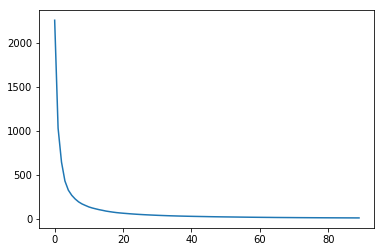

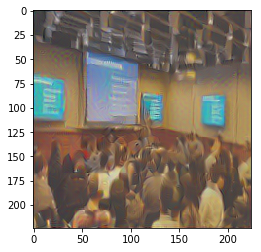

In [9]:
import cv2
import numpy as np
 
path = 'van-gogh-bedroom.jpg'
frame = image.load_img(path)
frame = image.img_to_array(img)
# frame = np.expand_dims(frame,axis=0)    
# x = preprocess_input(x)


# Create a VideoCapture object
batch_shape = style_img.shape
shape = style_img.shape[1:]
# cap = cv2.VideoCapture('D:/data_science/vedio/out.avi')
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4)) 
# # Check if camera opened successfully
# if (cap.isOpened() == False): 
#     print("Unable to read camera feed")
 
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# out = cv2.VideoWriter('D:/data_science/vedio/outpy.avi',cv2.VideoWriter_fourcc(*'MJPG'),20.0,(224,224))
# count = 0 
# while(True):
# ret, frame = cap.read()
frame = cv2.resize(frame,(224,224))
X = preprocess_img(frame)
vgg = vgg_avg_pooling(shape=shape)
content_model = Model(vgg.input,vgg.layers[13].get_output_at(0))
content_target = content_model.predict(X)
symb_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
multi_output_model = Model(vgg.input, symb_conv_outputs)
symb_layer_out = [K.variable(y) for y in multi_output_model.predict(style_img)]
weights = [0.2,0.4,0.3,0.5,0.2]

loss=K.mean(K.square(content_model.output-content_target)) *4 
for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
    loss += 0.03 * w * style_loss(symb[0],actual[0])

grad = K.gradients(loss,vgg.input)
get_loss_grad = K.function(inputs=[vgg.input], outputs=[loss] + grad)
def get_loss_grad_wrapper(x_vec):
    l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)
final_img = min_loss(fn=get_loss_grad_wrapper,epochs=90,batch_shape=batch_shape)
plt.imshow(scale(final_img))
plt.show()
    
    
    #cv2.imshow('output',frame)
    #out.write(final_img)
filename ="final.jpg"  
cv2.imwrite(filename, final_img)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
     
    # Write the frame into the file 'output.avi'
        
 
    # Display the resulting frame    
        
  # Break the loop
    #if k == 27:
    #    break 
 
# When everything done, release the video capture and video write objects
# cap.release()
# out.release()
cv2.destroyAllWindows()